In [2]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL.Image as Image
import os
import glob


In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(64*4*4*4*4, 64),
                nn.ReLU(),
                nn.Linear(64, 2),
                nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.convolutional(x)

        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)

        return x


In [5]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [6]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    def loss_fun(output, target):
        return F.nll_loss(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(loss_fun(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")
    return out_dict

In [13]:
size = 128
aug_transforms = [
    transforms.Compose([transforms.Resize((size, size)), 
                        transforms.ToTensor()]),
    transforms.Compose([transforms.Resize((size*2, size*2)),
                        transforms.RandomCrop(size), 
                        transforms.ToTensor()]),                        
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor()]),  
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomRotation((-45, 45)), 
                        transforms.ToTensor()]),   
    transforms.Compose([transforms.Resize((size, size)), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    transforms.Compose([transforms.Resize((size*2, size*2)),
                        transforms.RandomCrop(size), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),                      
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomHorizontalFlip(), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    transforms.Compose([transforms.Resize((size, size)),
                        transforms.RandomRotation((-45, 45)), 
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
]



In [14]:
model_results = {
    'adam': [],
    'sgd': []
    }
batch_size = 64
for trans in aug_transforms:
    trainset = Hotdog_NotHotdog(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = Hotdog_NotHotdog(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

    model = Net()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters())
    model_results['adam'].append(train(model, optimizer))

for trans in aug_transforms:
    trainset = Hotdog_NotHotdog(train=True, transform=trans)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    testset = Hotdog_NotHotdog(train=False, transform=trans)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

    model = Net()
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    model_results['sgd'].append(train(model, optimizer))

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.700	 test: 0.673	 Accuracy train: 52.0%	 test: 67.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.574	 test: 0.552	 Accuracy train: 71.3%	 test: 71.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.518	 test: 0.545	 Accuracy train: 75.1%	 test: 73.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.492	 test: 0.534	 Accuracy train: 76.5%	 test: 73.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.478	 test: 0.517	 Accuracy train: 77.8%	 test: 74.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.431	 test: 0.519	 Accuracy train: 80.5%	 test: 75.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.404	 test: 0.531	 Accuracy train: 82.7%	 test: 75.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.358	 test: 0.487	 Accuracy train: 84.8%	 test: 76.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.325	 test: 0.592	 Accuracy train: 86.0%	 test: 76.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.299	 test: 0.540	 Accuracy train: 86.6%	 test: 77.8%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.652	 test: 0.610	 Accuracy train: 63.9%	 test: 67.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.591	 test: 0.627	 Accuracy train: 70.2%	 test: 66.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.575	 test: 0.578	 Accuracy train: 71.6%	 test: 71.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.531	 test: 0.637	 Accuracy train: 74.6%	 test: 70.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.526	 test: 0.541	 Accuracy train: 75.8%	 test: 73.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.542	 Accuracy train: 76.2%	 test: 73.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.495	 test: 0.538	 Accuracy train: 77.6%	 test: 74.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.487	 test: 0.528	 Accuracy train: 77.4%	 test: 74.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.486	 test: 0.524	 Accuracy train: 77.0%	 test: 74.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.473	 test: 0.531	 Accuracy train: 78.4%	 test: 74.9%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.683	 test: 0.630	 Accuracy train: 56.4%	 test: 66.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.577	 test: 0.545	 Accuracy train: 72.2%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.517	 test: 0.596	 Accuracy train: 74.7%	 test: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.505	 test: 0.532	 Accuracy train: 76.6%	 test: 74.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.487	 test: 0.519	 Accuracy train: 77.2%	 test: 74.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.475	 test: 0.563	 Accuracy train: 79.2%	 test: 74.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.464	 test: 0.508	 Accuracy train: 78.5%	 test: 75.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.441	 test: 0.515	 Accuracy train: 80.3%	 test: 75.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.424	 test: 0.505	 Accuracy train: 81.0%	 test: 77.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.379	 test: 0.548	 Accuracy train: 83.2%	 test: 76.0%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.635	 test: 0.560	 Accuracy train: 62.4%	 test: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.540	 test: 0.533	 Accuracy train: 73.7%	 test: 72.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.511	 test: 0.543	 Accuracy train: 75.5%	 test: 72.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.499	 test: 0.542	 Accuracy train: 76.5%	 test: 73.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.490	 test: 0.548	 Accuracy train: 78.0%	 test: 70.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.481	 test: 0.577	 Accuracy train: 77.5%	 test: 71.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.470	 test: 0.491	 Accuracy train: 79.2%	 test: 75.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.446	 test: 0.477	 Accuracy train: 79.3%	 test: 77.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.421	 test: 0.461	 Accuracy train: 81.2%	 test: 78.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.405	 test: 0.465	 Accuracy train: 82.6%	 test: 79.3%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.664	 test: 0.617	 Accuracy train: 59.6%	 test: 64.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.550	 test: 0.541	 Accuracy train: 73.9%	 test: 74.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.506	 test: 0.560	 Accuracy train: 76.5%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.485	 test: 0.516	 Accuracy train: 77.2%	 test: 74.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.452	 test: 0.521	 Accuracy train: 78.9%	 test: 74.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.426	 test: 0.509	 Accuracy train: 81.5%	 test: 75.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.389	 test: 0.582	 Accuracy train: 83.5%	 test: 74.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.327	 test: 0.598	 Accuracy train: 86.6%	 test: 71.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.316	 test: 0.570	 Accuracy train: 85.7%	 test: 74.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.246	 test: 0.632	 Accuracy train: 90.2%	 test: 75.1%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.625	 test: 0.577	 Accuracy train: 65.4%	 test: 70.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.549	 test: 0.553	 Accuracy train: 74.1%	 test: 72.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.556	 test: 0.571	 Accuracy train: 73.1%	 test: 72.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.527	 test: 0.542	 Accuracy train: 75.0%	 test: 72.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.515	 test: 0.542	 Accuracy train: 75.3%	 test: 73.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.498	 test: 0.540	 Accuracy train: 76.4%	 test: 73.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.502	 test: 0.531	 Accuracy train: 75.7%	 test: 74.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.480	 test: 0.579	 Accuracy train: 77.0%	 test: 71.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.481	 test: 0.541	 Accuracy train: 77.9%	 test: 73.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.469	 test: 0.517	 Accuracy train: 78.6%	 test: 75.3%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.623	 test: 0.553	 Accuracy train: 65.7%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.522	 test: 0.546	 Accuracy train: 74.7%	 test: 73.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.490	 test: 0.532	 Accuracy train: 76.6%	 test: 73.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.469	 test: 0.502	 Accuracy train: 77.4%	 test: 75.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.438	 test: 0.557	 Accuracy train: 79.6%	 test: 75.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.413	 test: 0.504	 Accuracy train: 81.1%	 test: 76.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.377	 test: 0.550	 Accuracy train: 82.9%	 test: 73.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.351	 test: 0.481	 Accuracy train: 83.4%	 test: 76.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.322	 test: 0.477	 Accuracy train: 86.0%	 test: 78.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.275	 test: 0.516	 Accuracy train: 89.2%	 test: 76.8%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.619	 test: 0.554	 Accuracy train: 66.9%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.523	 test: 0.525	 Accuracy train: 74.4%	 test: 74.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.496	 test: 0.530	 Accuracy train: 75.7%	 test: 74.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.477	 test: 0.501	 Accuracy train: 77.6%	 test: 76.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.459	 test: 0.491	 Accuracy train: 79.2%	 test: 76.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.432	 test: 0.506	 Accuracy train: 79.5%	 test: 76.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.421	 test: 0.554	 Accuracy train: 81.0%	 test: 74.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.431	 test: 0.479	 Accuracy train: 79.7%	 test: 76.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.393	 test: 0.463	 Accuracy train: 81.4%	 test: 78.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.386	 test: 0.491	 Accuracy train: 81.8%	 test: 77.0%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.693	 test: 0.696	 Accuracy train: 52.0%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.691	 test: 0.694	 Accuracy train: 53.0%	 test: 48.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.682	 test: 0.677	 Accuracy train: 57.3%	 test: 63.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.664	 test: 0.675	 Accuracy train: 59.4%	 test: 54.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.654	 test: 0.667	 Accuracy train: 62.9%	 test: 60.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.618	 test: 0.620	 Accuracy train: 68.2%	 test: 69.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.581	 test: 0.562	 Accuracy train: 71.9%	 test: 70.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.560	 test: 0.535	 Accuracy train: 73.0%	 test: 73.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.516	 test: 0.589	 Accuracy train: 76.3%	 test: 67.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.513	 test: 0.557	 Accuracy train: 75.5%	 test: 71.9%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.700	 Accuracy train: 52.1%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.689	 test: 0.688	 Accuracy train: 54.5%	 test: 51.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.681	 test: 0.691	 Accuracy train: 57.2%	 test: 53.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.669	 test: 0.663	 Accuracy train: 62.1%	 test: 61.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.635	 test: 0.655	 Accuracy train: 64.9%	 test: 59.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.636	 test: 0.613	 Accuracy train: 65.9%	 test: 68.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.608	 test: 0.619	 Accuracy train: 68.5%	 test: 66.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.610	 test: 0.688	 Accuracy train: 68.9%	 test: 57.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.603	 test: 0.594	 Accuracy train: 68.9%	 test: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.591	 test: 0.609	 Accuracy train: 71.1%	 test: 68.6%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.692	 test: 0.696	 Accuracy train: 52.0%	 test: 48.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.686	 test: 0.678	 Accuracy train: 55.2%	 test: 67.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.669	 test: 0.646	 Accuracy train: 60.1%	 test: 68.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.626	 test: 0.619	 Accuracy train: 68.6%	 test: 68.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.578	 test: 0.615	 Accuracy train: 71.5%	 test: 70.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.555	 test: 0.547	 Accuracy train: 73.2%	 test: 72.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.528	 test: 0.534	 Accuracy train: 75.3%	 test: 73.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.518	 test: 0.518	 Accuracy train: 75.9%	 test: 74.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.505	 test: 0.516	 Accuracy train: 76.9%	 test: 75.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.491	 test: 0.551	 Accuracy train: 78.4%	 test: 73.4%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.690	 test: 0.686	 Accuracy train: 54.1%	 test: 52.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.680	 test: 0.665	 Accuracy train: 59.2%	 test: 65.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.669	 test: 0.678	 Accuracy train: 61.8%	 test: 56.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.643	 test: 0.619	 Accuracy train: 66.4%	 test: 71.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.585	 test: 0.555	 Accuracy train: 71.0%	 test: 72.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.593	 test: 0.630	 Accuracy train: 69.5%	 test: 66.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.638	 test: 0.647	 Accuracy train: 66.0%	 test: 64.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.555	 test: 0.546	 Accuracy train: 73.2%	 test: 72.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.529	 test: 0.627	 Accuracy train: 75.7%	 test: 64.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.521	 test: 0.564	 Accuracy train: 75.5%	 test: 71.9%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.688	 test: 0.680	 Accuracy train: 55.3%	 test: 59.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.647	 test: 0.573	 Accuracy train: 64.3%	 test: 72.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.590	 test: 0.548	 Accuracy train: 71.3%	 test: 72.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.537	 test: 0.604	 Accuracy train: 75.1%	 test: 70.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.525	 test: 0.617	 Accuracy train: 75.2%	 test: 64.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.505	 test: 0.546	 Accuracy train: 76.4%	 test: 73.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.509	 test: 0.550	 Accuracy train: 75.4%	 test: 73.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.482	 test: 0.535	 Accuracy train: 78.5%	 test: 74.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.470	 test: 0.537	 Accuracy train: 79.0%	 test: 73.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.476	 test: 0.572	 Accuracy train: 78.5%	 test: 72.8%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.669	 test: 0.664	 Accuracy train: 59.8%	 test: 62.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.626	 test: 0.612	 Accuracy train: 66.7%	 test: 67.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.617	 test: 0.628	 Accuracy train: 67.8%	 test: 67.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.596	 test: 0.583	 Accuracy train: 70.0%	 test: 71.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.618	 test: 0.671	 Accuracy train: 68.2%	 test: 61.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.595	 test: 0.596	 Accuracy train: 69.7%	 test: 70.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.576	 test: 0.596	 Accuracy train: 71.5%	 test: 68.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.574	 test: 0.740	 Accuracy train: 70.9%	 test: 54.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.568	 test: 0.592	 Accuracy train: 72.6%	 test: 71.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.573	 test: 0.563	 Accuracy train: 72.1%	 test: 72.4%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.672	 test: 0.668	 Accuracy train: 58.2%	 test: 62.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.602	 test: 0.564	 Accuracy train: 69.5%	 test: 72.2%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.579	 test: 0.634	 Accuracy train: 70.2%	 test: 67.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.546	 test: 0.555	 Accuracy train: 74.3%	 test: 72.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.525	 test: 0.533	 Accuracy train: 74.7%	 test: 73.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.496	 test: 0.561	 Accuracy train: 77.1%	 test: 73.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.518	 test: 0.542	 Accuracy train: 74.5%	 test: 73.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.499	 test: 0.532	 Accuracy train: 76.9%	 test: 73.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.489	 test: 0.743	 Accuracy train: 77.4%	 test: 58.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.502	 test: 0.599	 Accuracy train: 76.2%	 test: 72.1%


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.691	 test: 0.686	 Accuracy train: 53.0%	 test: 51.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.668	 test: 0.705	 Accuracy train: 60.1%	 test: 55.1%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.598	 test: 0.585	 Accuracy train: 69.3%	 test: 70.5%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.560	 test: 0.557	 Accuracy train: 72.1%	 test: 70.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.538	 test: 0.542	 Accuracy train: 74.8%	 test: 71.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.543	 test: 0.548	 Accuracy train: 74.5%	 test: 71.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.533	 test: 0.564	 Accuracy train: 73.7%	 test: 71.4%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.554	 test: 0.538	 Accuracy train: 73.1%	 test: 72.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.508	 test: 0.533	 Accuracy train: 75.7%	 test: 73.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.498	 test: 0.543	 Accuracy train: 76.3%	 test: 72.8%


In [21]:
best_model = {
    'optimizer': '',
    'id': -1,
    'accuracy': 0
}

for model_id in range(len(model_results['adam'])):
    sgd_acc = model_results['sgd'][model_id]['test_acc'][len(model_results['sgd'][model_id])]
    adam_acc = model_results['adam'][model_id]['test_acc'][len(model_results['sgd'][model_id])]
    if sgd_acc > adam_acc:
        if sgd_acc > best_model['accuracy']:
            best_model['optimizer'] = 'sgd'
            best_model['id'] = model_id
            best_model['accuracy'] = sgd_acc
    else:
        best_model['optimizer'] = 'adam'
        best_model['id'] = model_id
        best_model['accuracy'] = adam_acc
    print('sgd:', model_results['sgd'][model_id]['test_acc'][len(model_results['sgd'][model_id])])
    print('adam:', model_results['adam'][model_id]['test_acc'][len(model_results['sgd'][model_id])])
    print()


sgd: 0.6015037593984962
adam: 0.7406015037593985

sgd: 0.5977443609022557
adam: 0.7320085929108485

sgd: 0.7073039742212675
adam: 0.7491944146079484

sgd: 0.7266380236305048
adam: 0.7073039742212675

sgd: 0.6428571428571429
adam: 0.7438238453276047

sgd: 0.6181525241675617
adam: 0.7352309344790547

sgd: 0.7309344790547798
adam: 0.7561761546723953

sgd: 0.7175080558539205
adam: 0.7647690655209453



{'optimizer': 'adam', 'id': 7, 'accuracy': 0.7647690655209453}


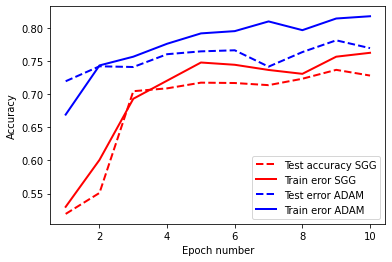

In [22]:
print(best_model)
plt.plot(range(1,11), model_results['sgd'][best_model['id']]['test_acc'], color='red', linestyle='dashed', linewidth=2)
plt.plot(range(1,11), model_results['sgd'][best_model['id']]['train_acc'], color='red', linewidth=2)
plt.plot(range(1,11), model_results['adam'][best_model['id']]['test_acc'], color='blue', linestyle='dashed', linewidth=2)
plt.plot(range(1,11), model_results['adam'][best_model['id']]['train_acc'], color='blue', linewidth=2)
plt.legend(('Test accuracy SGG','Train eror SGG','Test error ADAM','Train eror ADAM'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()